In [11]:
import pandas as pd
import requests as rq
import time
import json
from langchain_ollama import OllamaLLM
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
from transformers import pipeline


import logging

logging.getLogger("transformers").setLevel(logging.ERROR)


In [2]:
llm = OllamaLLM(model="llama3:8b")

In [3]:
def get_ollama_response(text):
    prompt = f"""Please analyse the following text and
    give response only in json format and no other extra text as {{"score":<SCORE>, "justification":<JUST>"}}, 
    here <SCORE> is sentiment score between -1 to 1 (where -1 is most negative, 0 is neutral and 1 is most positive)
    and <JUST> is Justification for why you choose this sentiment score
    Text: {text}"""

    try:
        response_text = llm.invoke(prompt)

        # print(response_text)

        # lines  = response_text.strip().split('\n')

        # score = float(lines[0])

        # justification = lines[1] if len(lines)>1 else "No justification provided"

        # score = max(min(score, 1.0), -1.0)

        return json.loads(response_text)

        # return {
        #     "score": score,
        #     "justification": justification
        # }

    except Exception as e:
        print(f"Error in processing: {str(e)}")
        return {
            "score": -2.0,
            "justification": f"Error in processing: {str(e)}"
        }



In [89]:
# def process_sentiment_analysis( model="llama_3_8b"):
#     df[f"sentiment_score_{model}"] = 0.0
#     df[f"sentiment_justification"] = ''
#     total_rows = len(df)

#     for idx, row in df.iterrows():
#         try:
#             result = get_ollama_response(row['text'])


#             df.at[idx, f"sentiment_score_{model}"] = result['score']
#             df.at[idx, f"sentiment_justification"] = result['justification']

#             time.sleep(0.5)

#             print(f"Processed {idx+1}/{total_rows} rows ({((idx+1)/total_rows * 100):.2f}%)")

#         except Exception as e:
#             print(f"Error processing row {idx}: {str(e)}")
#             continue


            
    

In [10]:
try:
    output_file= "data/Sentiment_analysis_Data_fin_result.csv"

    # process_sentiment_analysis()
finally:
    # df.to_csv(output_file, index=False)
    print(f"Analysis complete. Result saved to {output_file}")

Analysis complete. Result saved to data/Sentiment_analysis_Data_fin_result.csv


In [58]:
def calculate_SA_Polarity(text,model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"):
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name, force_download=False)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, force_download=False)
        inputs = tokenizer(text, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
            # print(f"Outputs: {outputs}")
            logits = outputs.logits.squeeze()
            # print(f"Logits: {logits}")

        
        probs = F.softmax(logits, dim=0)
        # print(f"Probs: {probs}")

        # Compute polarity score: (-1 * neg) + (0 * neutral) + (1 * pos)
        polarity = -probs[0] + probs[2]
        
        return polarity
    except Exception as e:
        print(str(e))
        return -2.5

In [90]:
input_file ="data/Sentiment_analysis_Data_fin_result.csv"
df = pd.read_csv(input_file)
df.columns

Index(['text', 'sentiment_score', 'sentiment_score_llama_3_8b',
       'sentiment_justification',
       'sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest',
       'sentiment_score_finiteautomata/bertweet-base-sentiment-analysis',
       'sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'],
      dtype='object')

In [85]:
def process_sentiment_analysis_comp( model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"):
    df[f"sentiment_score_{model}"] = 0.0
    total_rows = len(df)

    for idx, row in df.iterrows():
        try:
            input = row['text']
            result = calculate_SA_Polarity(input)
            print(f"Polarity of {input}: {result}")

            df.at[idx, f"sentiment_score_{model}"] = round(float(result), 2)


            print(f"Processed {idx+1}/{total_rows} rows ({((idx+1)/total_rows * 100):.2f}%)")

        except Exception as e:
            print(f"Error processing row {idx}: {str(e)}")
            continue

In [ ]:

try:
    output_file= "data/Sentiment_analysis_Data_fin_result.csv"
    

    # process_sentiment_analysis_comp()
finally:
    # df.to_csv(output_file, index=False)
    print(f"Analysis complete. Result saved to {output_file}")

Analysis complete. Result saved to data/Sentiment_analysis_Data_fin_result.csv


In [87]:
df.columns

Index(['text', 'sentiment_score', 'sentiment_score_llama_3_8b',
       'sentiment_justification',
       'sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest',
       'sentiment_score_finiteautomata/bertweet-base-sentiment-analysis',
       'sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'],
      dtype='object')

In [109]:
input_file ="data/Sentiment_analysis_Data_fin_result.csv"
df = pd.read_csv(input_file)
df.columns

Index(['text', 'sentiment_score', 'sentiment_score_llama_3_8b',
       'sentiment_justification',
       'sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest',
       'sentiment_score_finiteautomata/bertweet-base-sentiment-analysis',
       'sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'],
      dtype='object')

In [110]:
import matplotlib.pyplot as plt

In [111]:
# (df.head(500)['sentiment_score_llama_3_8b']-df.head(500)['sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest'])

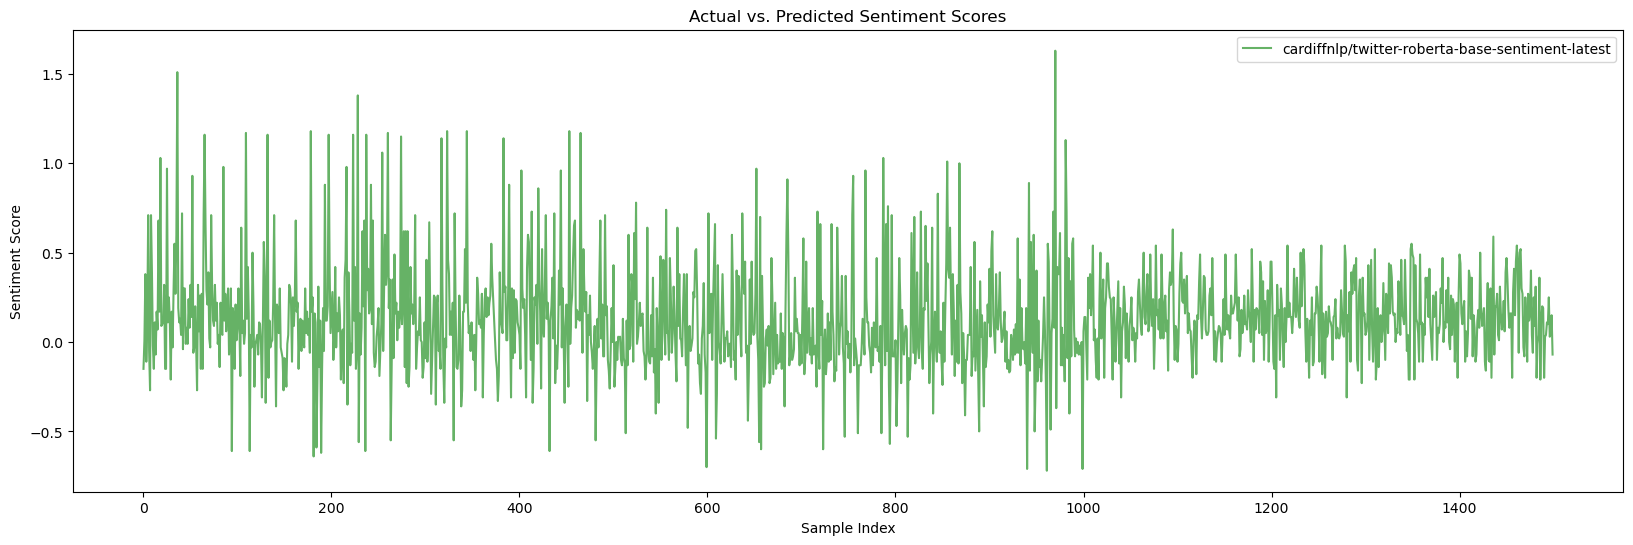

In [116]:
plt.figure(figsize=(20, 6))

# plt.plot(df.head(500)['sentiment_score_llama_3_8b'], color='black', label='Actual', alpha=0.6)
# plt.plot(df.head(500)['sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest'], color='blue', label='cardiffnlp/twitter-roberta-base-sentiment-latest', alpha=0.6)

plt.plot((df.head(1500)['sentiment_score_llama_3_8b']-df.head(1500)['sentiment_score_cardiffnlp/twitter-roberta-base-sentiment-latest']), color='green', label='cardiffnlp/twitter-roberta-base-sentiment-latest', alpha=0.6)

# plt.plot((df.head(500)['sentiment_score_llama_3_8b']-df.head(500)['sentiment_score_finiteautomata/bertweet-base-sentiment-analysis']), color='blue', label='finiteautomata/bertweet-base-sentiment-analysis', alpha=0.6)

# plt.plot((df.head(500)['sentiment_score_llama_3_8b']-df.head(500)['sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis']), color='red', label='mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis', alpha=0.6)

plt.xlabel('Sample Index')
plt.ylabel('Sentiment Score')
plt.title('Actual vs. Predicted Sentiment Scores')
plt.legend()
plt.show()

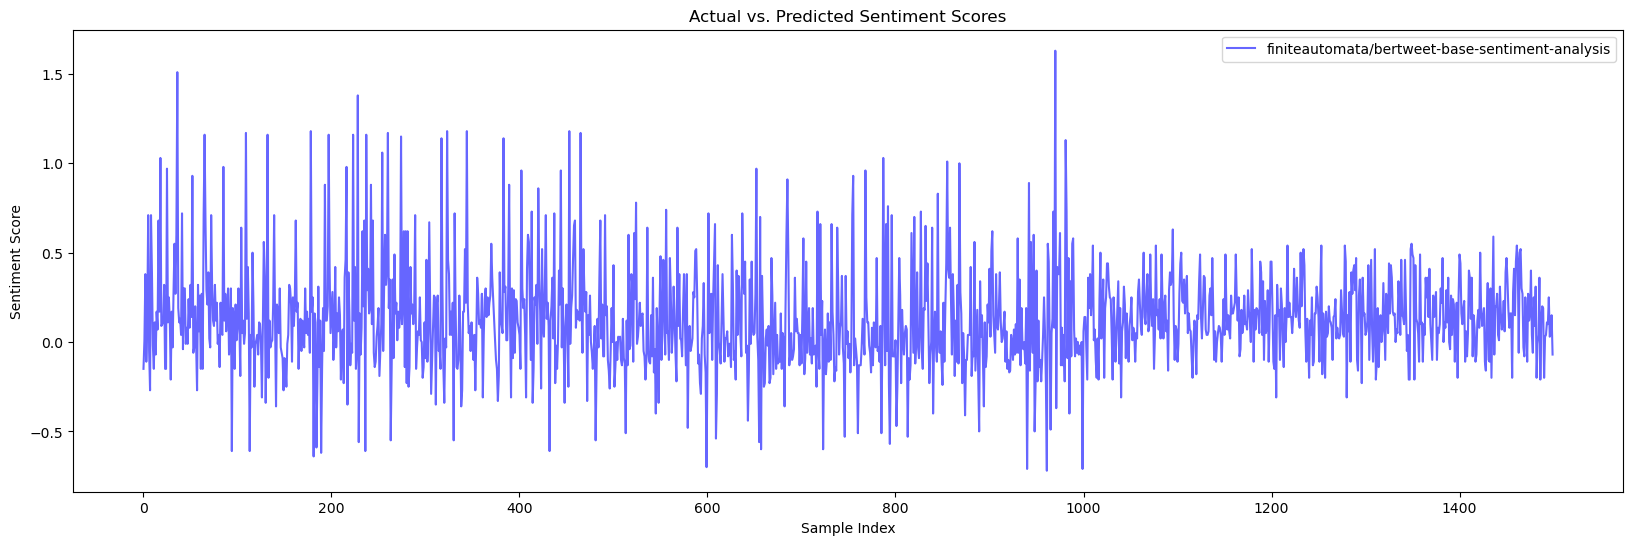

In [113]:
plt.figure(figsize=(20, 6))
plt.plot((df.head(1500)['sentiment_score_llama_3_8b']-df.head(1500)['sentiment_score_finiteautomata/bertweet-base-sentiment-analysis']), color='blue', label='finiteautomata/bertweet-base-sentiment-analysis', alpha=0.6)

# plt.plot((df.head(500)['sentiment_score_llama_3_8b']-df.head(500)['sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis']), color='red', label='mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis', alpha=0.6)

plt.xlabel('Sample Index')
plt.ylabel('Sentiment Score')
plt.title('Actual vs. Predicted Sentiment Scores')
plt.legend()
plt.show()

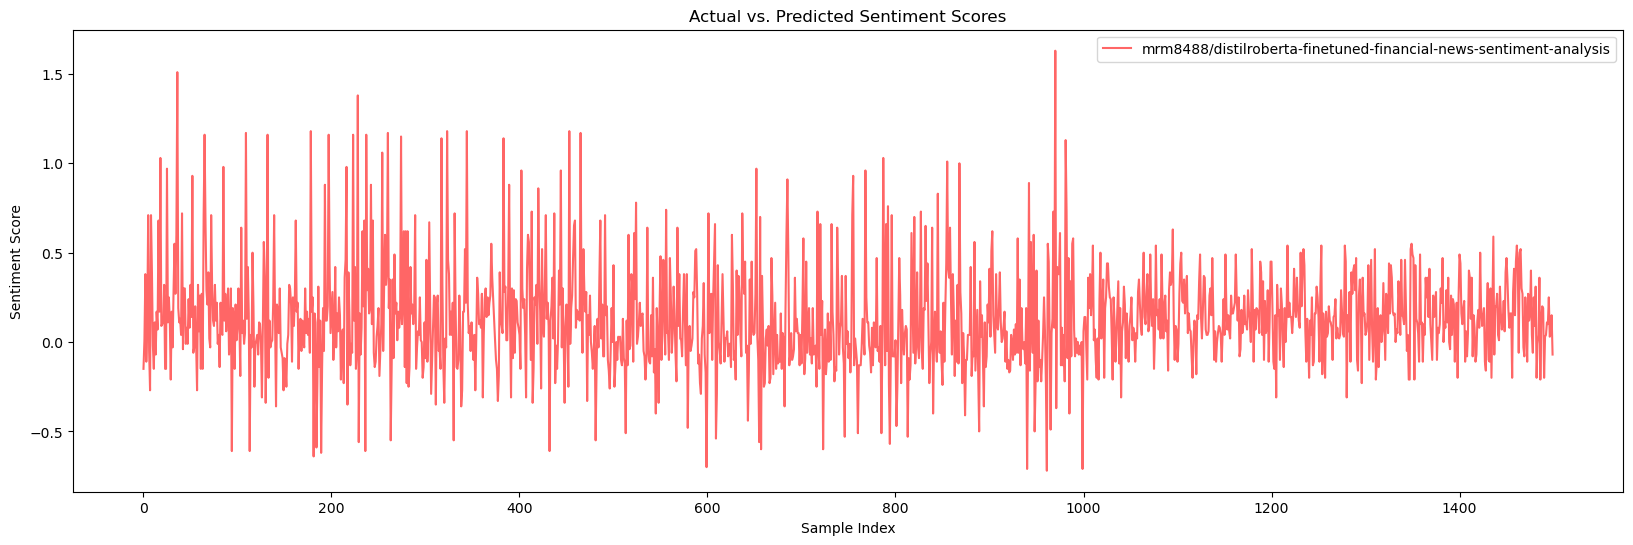

In [114]:
plt.figure(figsize=(20, 6))
plt.plot((df.head(1500)['sentiment_score_llama_3_8b']-df.head(1500)['sentiment_score_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis']), color='red', label='mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis', alpha=0.6)

plt.xlabel('Sample Index')
plt.ylabel('Sentiment Score')
plt.title('Actual vs. Predicted Sentiment Scores')
plt.legend()
plt.show()